#Introduction

The following report is divided into three sections:
1. **Data Analysis.**  \
Where static data extracted from production are analyzed. The focus of the report will be on the following columns:\
Article id: ART_ID \
Article version: ART_VER \
Article status: DDD_STATUS\
TIpology of Standard Pack (SPK or SPB): DDD_ART_UNIT_SP	\
Number of items in a standard pack: DDD_PACK_CONT_SP \
Unit gross pack in a bag (GPB): DDD_ART_UNIT_GP \
Number of articles in a gross pack bag: DDD_PACK_CONT_GP \
Unit gross pack in a box (GPX) DDD_ART_UNIT_GP2 \
Number of articles in a gross pack box: DDD_PACK_CONT_GP2 \

2. **Language harmonization.** \
The following columns were analyzed in this section:
GF_ART_ETI_LANG, GF_ART_NAME1_LN5, GF_ART_NAME2_LN5, GF_ART_NAME3_LN5, GF_ART_NAME4_LN5.
Where GF_ART_ETI_LANG represents the order of column languages separated by semicolon, for example:  DE;IT;FR;EN.
This causes the languages in the subsequent columns to be distributed as follows: \
DE: GF_ART_NAME1_LN5 \
EN: GF_ART_NAME2_LN5 \
FR: GF_ART_NAME3_LN5 \
EN: GF_ART_NAME4_LN5 \
Note: Language order may be missing or incorrect even with assigned columns, for example: "None", "E;-;-;-". Where"-" indicates missing languages. \
The goal of this section is to see if it is possible to have the language columns always in the same order, for example: DE;FR;EN;IT and in case it is possible, transform the data.

3. **Data quality, Cross-Functional Team Discussion.** \
This section will explain what are the issues and consequences of having inconsistent or dirty data and what could be possible actions to improve data quality.


In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
!ls

Mounted at /content/drive
drive  sample_data


In [2]:
!ls ./drive/MyDrive/GfCaseStudy

GfCaseStudy.ipynb  IF_EDMI_PRODDAT.xlsx


In [3]:
import pandas as pd
from matplotlib import pyplot as plt


class DataAnalysis:
    def __init__(self):
        df = pd.read_excel("./drive/MyDrive/GfCaseStudy/IF_EDMI_PRODDAT.xlsx")
        df = df.drop_duplicates(subset=['ART_ID', 'ART_VER'], keep='first')
        df = df[["ART_ID", "ART_VER", "DDD_STATUS", "DDD_ART_UNIT_SP", "DDD_PACK_CONT_SP", "DDD_ART_UNIT_GP", "DDD_PACK_CONT_GP", "DDD_ART_UNIT_GP2", "DDD_PACK_CONT_GP2"]]
        df.rename(columns={"DDD_ART_UNIT_GP": "DDD_ART_UNIT_GPB", "DDD_PACK_CONT_GP": "DDD_PACK_CONT_GPB"}, inplace=True)
        df.rename(columns={"DDD_ART_UNIT_GP2": "DDD_ART_UNIT_GPX", "DDD_PACK_CONT_GP2": "DDD_PACK_CONT_GPX"}, inplace=True)
        df['DDD_PACK_CONT_GPB'] = df['DDD_PACK_CONT_GPB'].astype(float)
        df['DDD_PACK_CONT_GPX'] = df['DDD_PACK_CONT_GPX'].astype(float)

        self.df = df 

        self.df_dirty = pd.DataFrame(columns=df.columns)

        df_temp = df.copy()
        #df_temp.dropna(subset=['DDD_ART_UNIT_SP'])
        df_temp = df_temp[(df_temp['DDD_PACK_CONT_GPB'] > 0) | (df_temp['DDD_PACK_CONT_GPX'] > 0) | (df_temp['DDD_PACK_CONT_SP'] > 0)]


        self.df_clean = df_temp
        self.df_dirty = df[~df.index.isin(self.df_clean.index)]

    def plot_art_package_analysis(self):
        df = self.df_clean
        df['X'] = df['DDD_ART_UNIT_GPB'].combine_first(df['DDD_ART_UNIT_GPX']).combine_first(df['DDD_ART_UNIT_SP'])

        df['Y'] = df.apply(lambda row: row['DDD_PACK_CONT_GPB']
            if row['X'] == 'GPB' else row['DDD_PACK_CONT_GPX'], axis=1)

        df['Y'] = df.apply(lambda row: row['DDD_PACK_CONT_SP']
        if 'SP' in row['X'] else row['Y'], axis=1)

        df.groupby(['X']).agg(
            {'Y': ['count', 'std', 'min', 'max', 'mean', 'sum']}).plot.bar(
            y='Y', logy=True)
        plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
        plt.rcParams['figure.figsize'] = [10, 10]
        plt.show()
    
    def plot_gp_analysis(self):
        df = self.df_clean
        df['X'] = df['DDD_ART_UNIT_GPB'].combine_first(df['DDD_ART_UNIT_GPX'])

        df['Y'] = df.apply(lambda row: row['DDD_PACK_CONT_GPB']
        if row['X'] == 'GPB' else row['DDD_PACK_CONT_GPX'], axis=1)

        df.groupby(['X']).agg(
            {'Y': ['count', 'std', 'min', 'max', 'mean', 'sum']}).plot.bar(
            y='Y', logy=True)
        plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
        plt.rcParams['figure.figsize'] = [10, 10]
        plt.show()

    def plot_articles_version_stats(self):
        df = self.df_clean
        plt.rcParams['figure.figsize'] = [10, 10]
        df.groupby('ART_ID').count().agg({'ART_VER': ['min', 'max', 'mean', 'std']}).plot.bar(y='ART_VER')
        plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
        plt.show()

    def plot_articles_with_many_active_versions(self):
        df = self.df_clean
        df = df[df['DDD_STATUS'] == 'n']
        df = df.groupby('ART_ID').count()
        df = df[df['ART_VER'] > 1]
        plt.rcParams['figure.figsize'] = [5, 5]
        df['ART_VER'].plot.bar()
        plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
        plt.show()

    def plot_articles_with_many_active_versions_all_df(self):
        df = self.df
        df = df[df['DDD_STATUS'] == 'n']
        df = df.groupby('ART_ID').count()
        df = df[df['ART_VER'] > 1]
        plt.rcParams['figure.figsize'] = [10, 10]
        df['ART_VER'].plot.bar()
        plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
        plt.show()

    def plot_articles_with_version_id_repetitions(self):
        df = self.df_clean
        df = df.groupby('ART_ID').value_counts().to_frame(name='ART_VER_COUNT').agg(
            {'ART_VER_COUNT': ['min', 'max', 'mean']})
        plt.rcParams['figure.figsize'] = [10, 10]
        df.plot.bar()
        plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
        plt.show()

    def analise_articles_with_version_id_repetitions(self):
        df = self.df_clean
        df_temp = df.drop_duplicates(subset=['ART_ID', 'ART_VER'], keep='first')
        df = df[~df.index.isin(df_temp.index)]
        print(df.shape)

    def plot_sp_analysis(self):
        df = self.df_clean
        df.groupby('DDD_ART_UNIT_SP').agg({'DDD_PACK_CONT_SP': ['count', 'std', 'min', 'max', 'mean', 'sum']}).plot.bar(
            y='DDD_PACK_CONT_SP', logy=True)
        plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
        plt.show()

    def plot_gp_analysis_group_by_sb(self):
        df = self.df_clean
        df['X'] = df['DDD_ART_UNIT_GPB'].combine_first(df['DDD_ART_UNIT_GPX'])

        #if in X if GPB DDD_PACK_CONT_GPB on Y else DDD_PACK_CONT_GPX
        df['Y'] = df.apply(lambda row: row['DDD_PACK_CONT_GPB']
        if row['X'] == 'GPB' else row['DDD_PACK_CONT_GPX'], axis=1)

        df.groupby(['X', 'DDD_ART_UNIT_SP']).agg(
            {'Y': ['count', 'std', 'min', 'max', 'mean', 'sum']}).plot.bar(
            y='Y', logy=True)
        plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
        plt.rcParams['figure.figsize'] = [10, 10]
        plt.show()

    def plot_inconsistent_case(self):
        df_dirty = self.df_dirty
        df_clean = self.df_clean

        df_clean['clean'] = True
        df_dirty['clean'] = False
        df = pd.concat([df_clean, df_dirty])

        df.groupby(['clean']).agg({'ART_ID': ['count']}).plot.bar(y='ART_ID')
        plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
        plt.show()


    def plot_inconsistent_case_analysis(self):
        df_dirty = self.df_dirty

        df_dirty['X'] = df_dirty['DDD_ART_UNIT_GPB'].combine_first(df_dirty['DDD_ART_UNIT_GPX'])

        df_dirty.groupby(['DDD_ART_UNIT_SP', 'X'], dropna=False).agg({'DDD_PACK_CONT_SP': ['count', 'std', 'min', 'max']}).plot.bar(
            y='DDD_PACK_CONT_SP', logy=True)
        plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
        plt.show()


    def plot_inconsistent_case_analysis_status(self):
        df_dirty = self.df_dirty
        df_dirty.groupby(['DDD_STATUS']).agg({'ART_ID': ['count']}).plot.bar(y='ART_ID')
        plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
        plt.show()
    
    def plot_gp_analysis_group_by_sb_combined_count(self):
        df = self.df_clean
        df['X'] = df['DDD_ART_UNIT_GPB'].combine_first(df['DDD_ART_UNIT_GPX'])

        df['Y'] = df.apply(lambda row: row['DDD_PACK_CONT_GPB']
            if row['X'] == 'GPB' else row['DDD_PACK_CONT_GPX'], axis=1)

        #combine count from Y and DDD_PACK_CONT_SP with multiplier if DDD_PACK_CONT_SP!=0 elst Y
        df['Z'] = df.apply(lambda row: row['Y'] if row['DDD_PACK_CONT_SP'] == 0 else row['Y'] * row['DDD_PACK_CONT_SP'], axis=1)
                    
        df.groupby(['X', 'DDD_ART_UNIT_SP']).agg(
            {'Z': ['count', 'std', 'min', 'max', 'mean', 'sum']}).plot.bar(
            y='Z', logy=True)
        plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
        plt.rcParams['figure.figsize'] = [10, 10]
        plt.show()

In [4]:
da = DataAnalysis()

#Task A: Data Analysis
I analyzed the first task with python. I decided to split the data into two: reliable and unreliable. I used the following filter:  
df = df[(df['DDD_PACK_CONT_GPB'] > 0) |(df['DDD_PACK_CONT_GPX'] > 0) | (df['DDD_PACK_CONT_SP']> 0)]


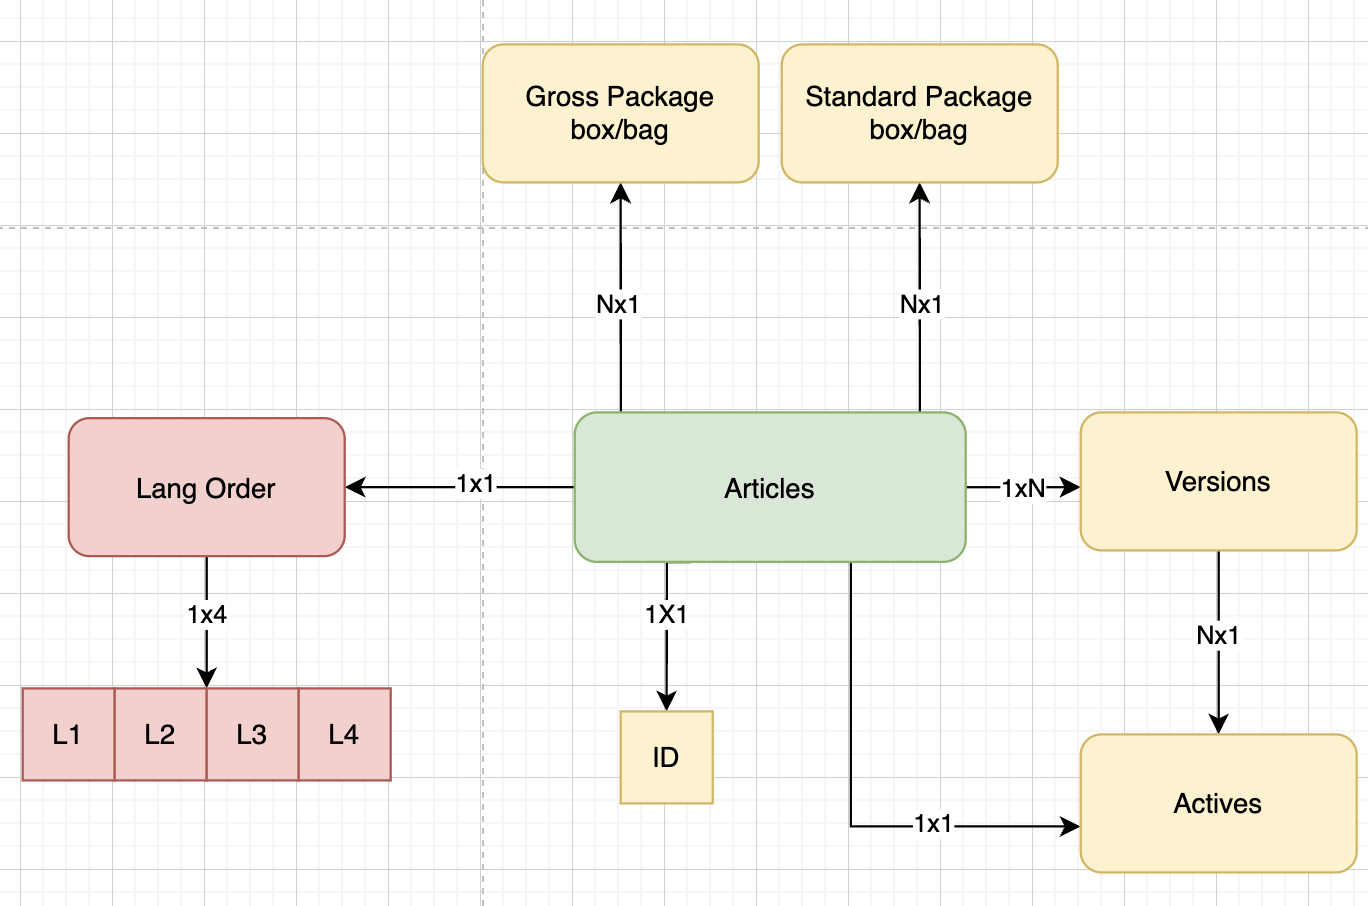

##Raw Data

In [5]:
da.df.iloc[0:10]

,ART_ID,ART_VER,DDD_STATUS,DDD_ART_UNIT_SP,DDD_PACK_CONT_SP,DDD_ART_UNIT_GPB,DDD_PACK_CONT_GPB,DDD_ART_UNIT_GPX,DDD_PACK_CONT_GPX
0,800071963,A,y,SPK,1.0,NaN,0.0,NaN,0.0
1,790151026,A,n,SPK,1.0,NaN,0.0,NaN,0.0
2,159900141,N,y,NaN,0.0,NaN,0.0,NaN,0.0
3,159900216,A,y,NaN,0.0,NaN,0.0,NaN,0.0
4,159832025,01,y,NaN,0.0,NaN,0.0,NaN,0.0
5,200012442,A,y,NaN,0.0,NaN,0.0,NaN,0.0
6,200012443,A,y,NaN,0.0,NaN,0.0,NaN,0.0
7,800071928,A,y,SPK,1.0,NaN,0.0,NaN,0.0
8,800071929,A,y,SPK,1.0,NaN,0.0,NaN,0.0
9,800071930,A,y,SPK,1.0,NaN,0.0,NaN,0.0


##Cleaned Data
These are the data that satisfy the expression mentioned earlier.

In [6]:
da.df_clean.iloc[0:10]

,ART_ID,ART_VER,DDD_STATUS,DDD_ART_UNIT_SP,DDD_PACK_CONT_SP,DDD_ART_UNIT_GPB,DDD_PACK_CONT_GPB,DDD_ART_UNIT_GPX,DDD_PACK_CONT_GPX
0,800071963,A,y,SPK,1.0,NaN,0.0,NaN,0.0
1,790151026,A,n,SPK,1.0,NaN,0.0,NaN,0.0
7,800071928,A,y,SPK,1.0,NaN,0.0,NaN,0.0
8,800071929,A,y,SPK,1.0,NaN,0.0,NaN,0.0
9,800071930,A,y,SPK,1.0,NaN,0.0,NaN,0.0
10,800071931,A,y,SPK,1.0,NaN,0.0,NaN,0.0
11,800071932,A,y,SPK,1.0,NaN,0.0,NaN,0.0
12,800071933,A,y,SPK,1.0,NaN,0.0,NaN,0.0
13,800071934,A,y,SPK,1.0,NaN,0.0,NaN,0.0
14,800071935,A,y,SPK,1.0,NaN,0.0,NaN,0.0


##Inconsistent Data

Data that do not satisfy the expression mentioned before testo in corsivo

In [7]:
da.df_dirty.iloc[0:10]

,ART_ID,ART_VER,DDD_STATUS,DDD_ART_UNIT_SP,DDD_PACK_CONT_SP,DDD_ART_UNIT_GPB,DDD_PACK_CONT_GPB,DDD_ART_UNIT_GPX,DDD_PACK_CONT_GPX
2,159900141,N,y,NaN,0.0,NaN,0.0,NaN,0.0
3,159900216,A,y,NaN,0.0,NaN,0.0,NaN,0.0
4,159832025,01,y,NaN,0.0,NaN,0.0,NaN,0.0
5,200012442,A,y,NaN,0.0,NaN,0.0,NaN,0.0
6,200012443,A,y,NaN,0.0,NaN,0.0,NaN,0.0
27,20014A680,A,y,NaN,0.0,NaN,0.0,NaN,0.0
30,790156012HA,B,y,NaN,0.0,NaN,0.0,NaN,0.0
32,159864001,A,y,NaN,0.0,NaN,0.0,NaN,0.0
39,200171761,A,y,NaN,0.0,NaN,0.0,NaN,0.0
40,200171762,A,y,NaN,0.0,NaN,0.0,NaN,0.0


##Correlation between articles and versions

---


It can be seen that the minimum value is one, but there are also cases where it is greater than one, in the maximum case it is four. The standard deviation is very low and the mean value is close to one, so this means that most of the articles have only one version.

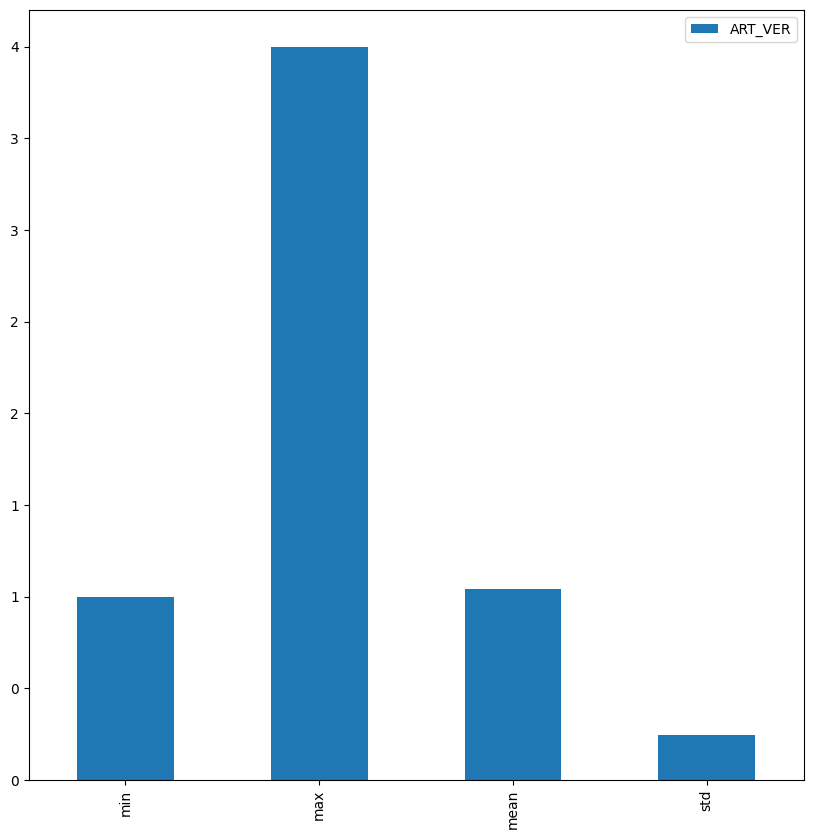

In [8]:
da.plot_articles_version_stats()

###Articles should have only one active version
Each article, across its various versions, should have only one active version. However, as visible from the graph, this is not always verified.

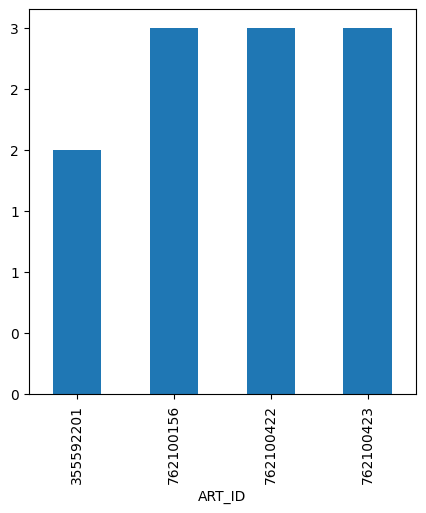

In [9]:
da.plot_articles_with_many_active_versions()

If we extend this analysis to data that are considered dirty, this phenomenon increases greatly.

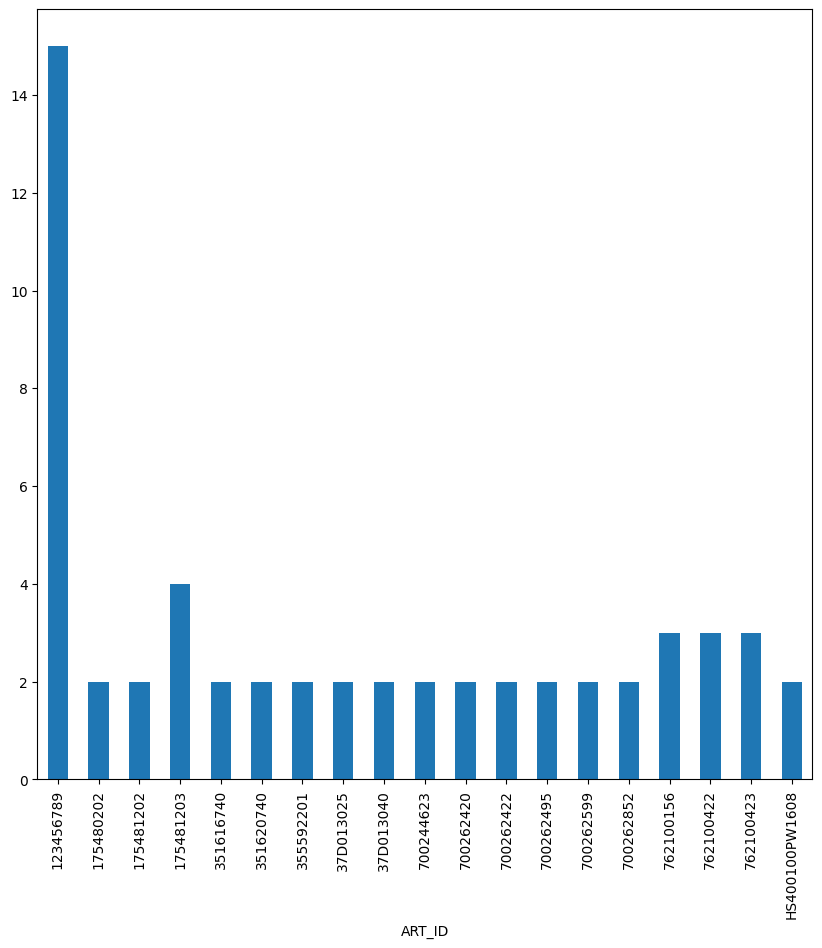

In [10]:
da.plot_articles_with_many_active_versions_all_df()

##Standard packs analysis
In this chart we have analyzed Standard packages.
They are of two types: Bag and Box.
Comparing the two types, we can say that:
1. Boxes, as far as Standard packages are concerned, are used more frequently: approximately 10 to 1.
2. Boxes have a larger standard deviation, so they tend to deviate more from the mean.
3. The minimum value for both is 0, while the maximum value is in the ratio of 100 to 1.
4. On average, SPB carry more items.
5. In the end, in term of numbers, SPX are slightly superior to SPB.

Notes: 
1. In this analysis, the size of the articles was not considered: column DDD_ART_DIM. 
2. probably Boxes are better for relatively small objects, this would explain the large difference in maximum value.

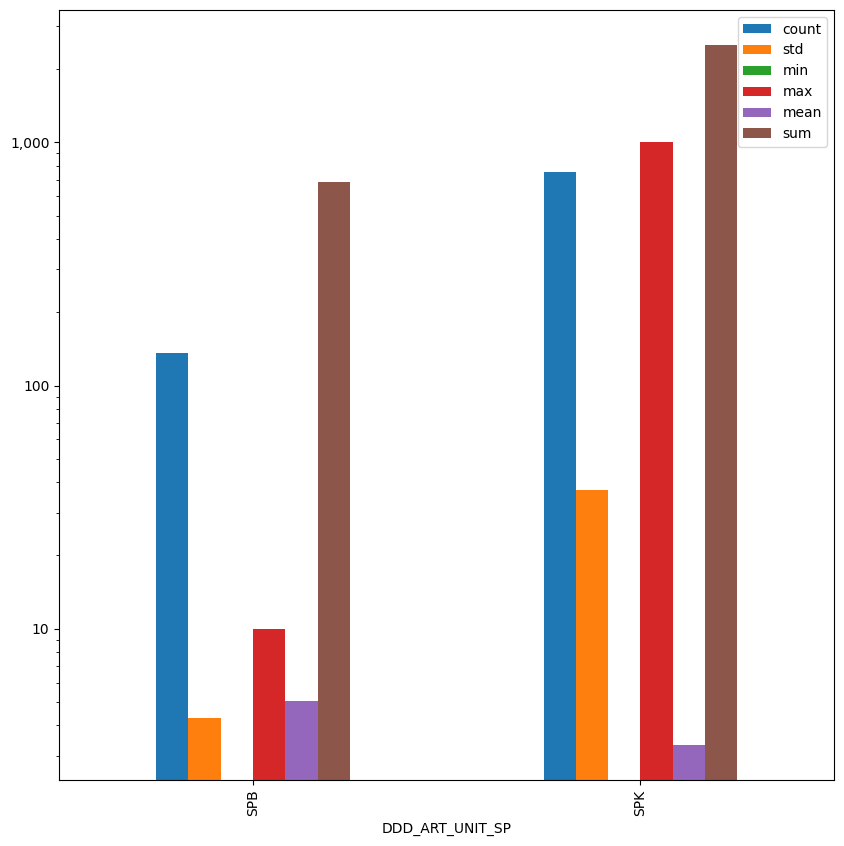

In [11]:
da.plot_sp_analysis()

##Gross packs analysis

It is possible to notice that GPK is the most commond choice,
The case that seems to contain the most items is GPB, 
however this should be considered carefully, 
since article: 360020220 has a capacity of 250000 items.

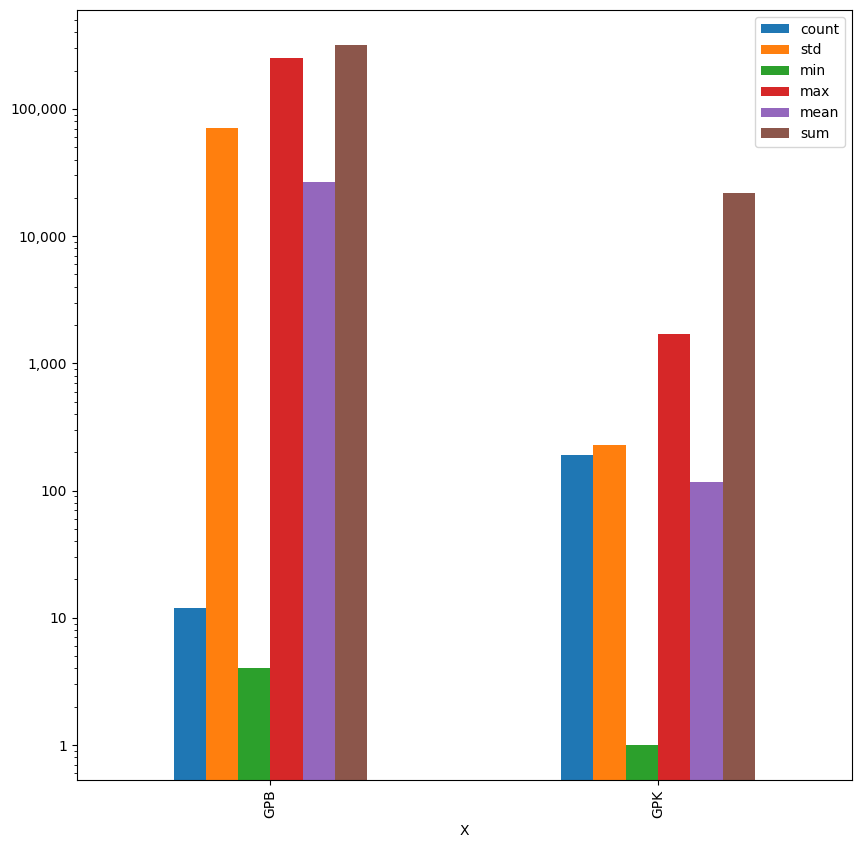

In [12]:
da.plot_gp_analysis()

### Standard Pack and Gross Pack joint analyis
It it possible to notice that boxes "GPK, SPK" is most commond choice.
It is also possible to notice that gross packs seams to be capable to carry more articles.
Finally, the min values are comparable.


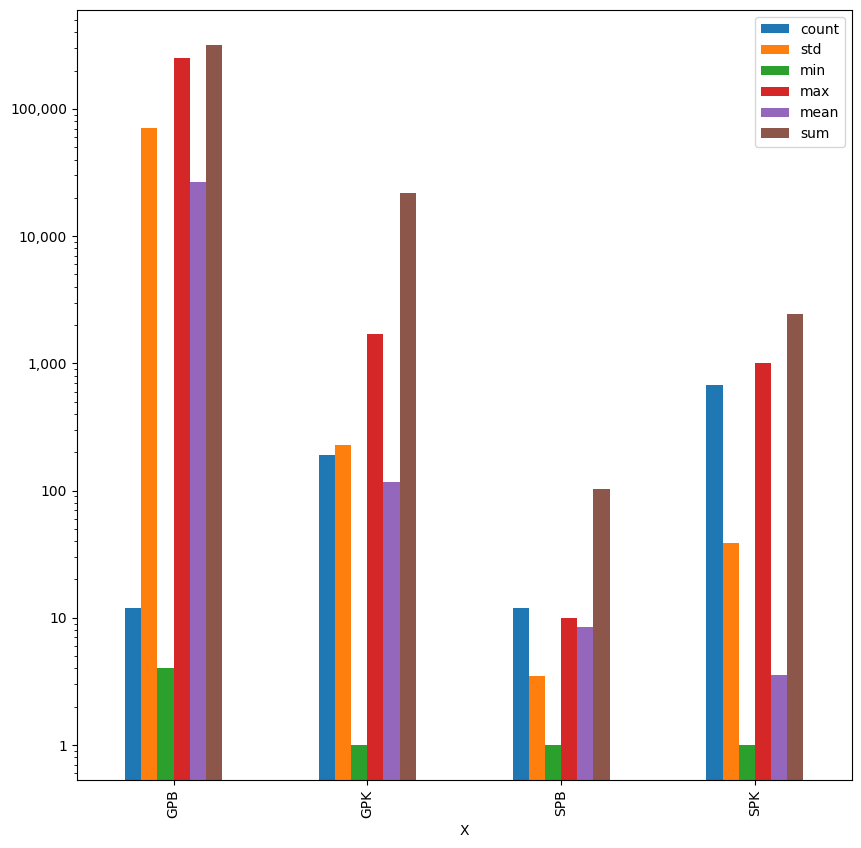

In [13]:
da.plot_art_package_analysis()

##Dirty data


###Quantify clean vs dirty data
In this graph we compare the amount of dirty data with the amount of clean data. Dirty data is in the majority.
Note that this analysis does not include any problems related to language incorrectness. In that case the dirty data may be even more.

<ipython-input-3-324f0ca83f8f>:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dirty['clean'] = False


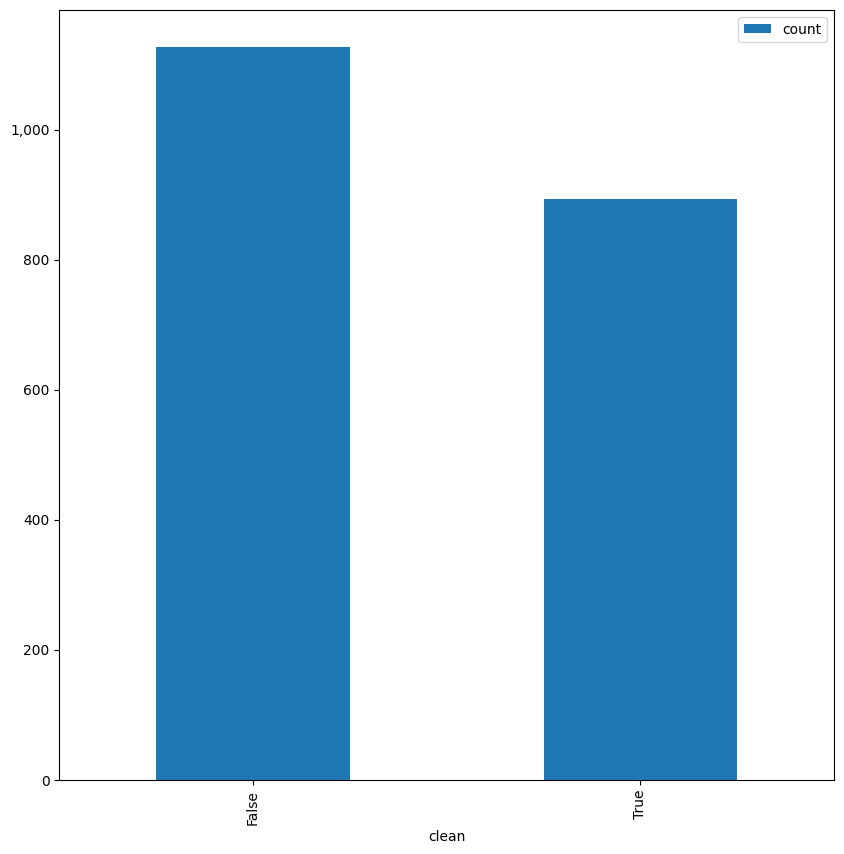

In [14]:
da.plot_inconsistent_case()

###Dirty data, split by Standard pack and Gross pack analysis

In this graph, you can see the statistics of the discarded data, apart from the instance count. It can be seen that the other statistics are all zero. These data have no value.

<ipython-input-3-324f0ca83f8f>:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dirty['X'] = df_dirty['DDD_ART_UNIT_GPB'].combine_first(df_dirty['DDD_ART_UNIT_GPX'])


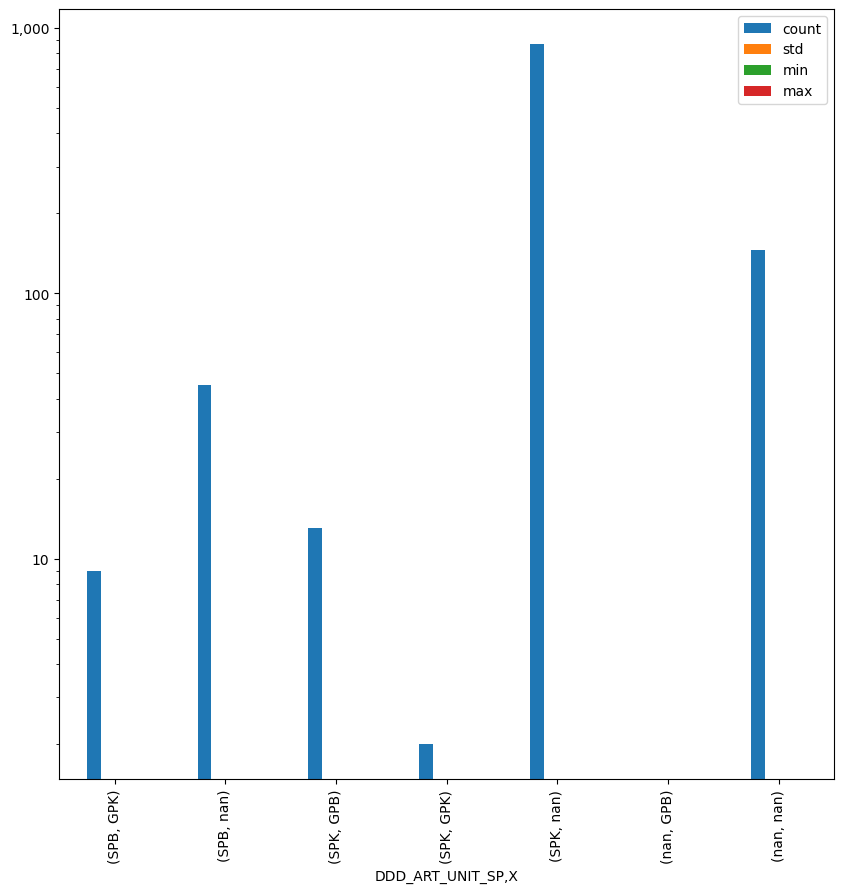

In [15]:
da.plot_inconsistent_case_analysis()

###Evaluate repetitions of article id and version id
There is no repetition of ART_ID and ART_VER when the other columns are different.

In [16]:
da.analise_articles_with_version_id_repetitions()

(0, 12)


#Task B: Language harmonization

It is possible to work on language harmonization. However, there are cases where the correct order "At least with standard techniques" cannot be established. I have noticed that typically the standard order is DE,FR,EN,IT
even if the column GF_ART_ETI_LANG is null. That is why I kept it as the default order.
Although this trick improves the result, it does not guarantee its correctness. We can therefore divide the data into three categories for this case: Correct, Uncertain, Incorrect.
The algorithm was developed as follows: if GF_ART_ETI_LANG is valued the languages are inserted into the columns with the default order for all valid languages.
On the other hand, if GF_ART_ETI_LANG is null, the values already present are kept. Finally, typos are treated as invalid and therefore skipped.

In [17]:
class DataAnalysisCleanLangs:
    def __init__(self):
        df = pd.read_excel("./drive/MyDrive/GfCaseStudy/IF_EDMI_PRODDAT.xlsx")
        self.df = df.drop_duplicates(subset=['ART_ID', 'ART_VER'], keep='first')

        self.col_reference = {
            "DE": "GF_ART_NAME1_LN5",
            "FR": "GF_ART_NAME2_LN5",
            "EN": "GF_ART_NAME3_LN5",
            "IT": "GF_ART_NAME4_LN5"
        }
        self.langs = list(self.col_reference.keys())


        self.df['LANG_STATUS'] = None

    def get_lang_order(self, row):
        curr_langs = []
        if row['GF_ART_ETI_LANG'] is not None and type(row['GF_ART_ETI_LANG']) is str:
            curr_langs = row['GF_ART_ETI_LANG'].split(';')

        return curr_langs

    def map_langs_status(self, row):
        if row['GF_ART_ETI_LANG'] is not None and type(row['GF_ART_ETI_LANG']) is str:
            langs = row['GF_ART_ETI_LANG'].split(';')
            if '-' in langs:
                langs.remove('-')
            if all(lang in self.langs for lang in langs):
                return 'Certain'
            else:
                return 'Incorrect'
        else:
            return 'Uncertain'


    def map_langs(self):
        df_copy = self.df.copy()
        for lang in self.langs:
            df_copy[self.col_reference[lang]] = None

        for index, row in self.df.iterrows():
            curr_langs = self.get_lang_order(row)

            for lang in curr_langs:
                if lang in self.langs:
                    pos = curr_langs.index(lang) + list(df_copy.columns).index('GF_ART_ETI_LANG')
                    df_copy.loc[index, self.col_reference[lang]] = row[df_copy.columns[pos + 1]]

            if len(curr_langs) == 0:
                df_copy.loc[index] = row

            df_copy.loc[index, 'LANG_STATUS'] = self.map_langs_status(row)

        for lang in self.langs:
            df_copy.rename(columns={self.col_reference[lang]: 'GF_ART_NAME_' + lang}, inplace=True)

        self.df = df_copy

    def plot_lang_status(self):
        df = self.df
        plt.rcParams['figure.figsize'] = [10, 5]
        df.groupby('LANG_STATUS').agg({'ART_ID': ['count']}).plot.bar(y='ART_ID')
        plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
        plt.show()


In [18]:
da_cl = DataAnalysisCleanLangs()
da_cl.map_langs()

<ipython-input-17-6523f1ea67bb>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['LANG_STATUS'] = None


##Example of harmonized languages

In [19]:
da_cl.df.iloc[0:100][['ART_ID', 'LANG_STATUS', 'GF_ART_ETI_LANG', 'GF_ART_NAME_DE', 'GF_ART_NAME_FR', 'GF_ART_NAME_EN', 'GF_ART_NAME_IT']]

,ART_ID,LANG_STATUS,GF_ART_ETI_LANG,GF_ART_NAME_DE,GF_ART_NAME_FR,GF_ART_NAME_EN,GF_ART_NAME_IT
0,800071963,Certain,DE;FR;EN;IT,Membranventil,Robinet à membrane,Diaphragm Valve,Valvola a Membrana
1,790151026,Certain,IT;EN;DE;FR,Hydraulik Aggregat,Unité hydraulique,Hydraulic unit,Centralina
2,159900141,Uncertain,NaN,NaN,NaN,NaN,NaN
3,159900216,Uncertain,NaN,NaN,NaN,NaN,NaN
4,159832025,Uncertain,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
95,199255467,Certain,DE;FR;EN;IT,Kugelhahn,Robinet à bille,Ball Valve,Valvola a Sfera
96,199255468,Certain,DE;FR;EN;IT,Kugelhahn,Robinet à bille,Ball Valve,Valvola a Sfera
97,199255469,Certain,DE;FR;EN;IT,Kugelhahn,Robinet à bille,Ball Valve,Valvola a Sfera
98,199255470,Certain,DE;FR;EN;IT,Kugelhahn,Robinet à bille,Ball Valve,Valvola a Sfera


## Some problematic examples
three problematic cases

In [20]:
da_cl.df[da_cl.df['ART_ID'].isin(["360094551", "360045556", "360013015"])][['ART_ID','LANG_STATUS', 'GF_ART_ETI_LANG', 'GF_ART_NAME_DE', 'GF_ART_NAME_FR', 'GF_ART_NAME_EN', 'GF_ART_NAME_IT']]

,ART_ID,LANG_STATUS,GF_ART_ETI_LANG,GF_ART_NAME_DE,GF_ART_NAME_FR,GF_ART_NAME_EN,GF_ART_NAME_IT
1035,360094551,Incorrect,E;-;-;-,None,None,None,None
2004,360045556,Uncertain,NaN,"GASTUBE,0.75,MPT,0.75,IPS,DR11,5.75L,SCH",Distributeur à 1 départ,Manifold 1-fold,Distributore a 1 partenza
2028,360013015,Uncertain,NaN,"RETAINER,12,IPS,DR7,TF",NaN,NaN,NaN


## Langs reliability
this graph shows three possible values:
Certain, uncertain, incorrect

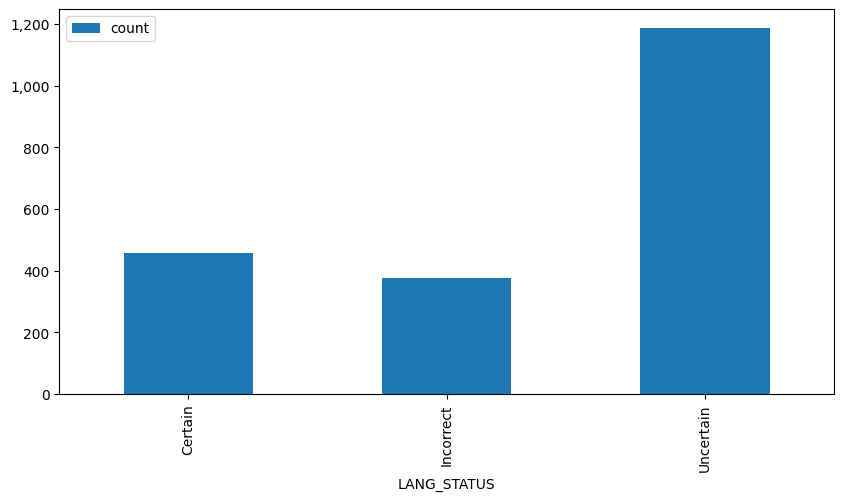

In [21]:
da_cl.plot_lang_status()

#Task C: Data quality


**Problems**
1. Languages: As shown in the graph above, they are often unreliable. Even in the cases considered as reliable, the input order of the languages is still done by hand and thus may be incorrect.

2. Duplicate active articles: There are cases where it turns out more than one version of an article is active.

3. Table names: Some names are unreadable. This makes data analysis difficult and expensive.

**Consequences**

1. If a customer does not know any language in the article, he may not be able to work. He would be forced to call support on an otherwise technical topic, and it could be that support does not know how to answer him or does not know his language.

2. What could happen if the selected item is not really active? Could obsolete or incorrect items be delivered? What would be the cost of this disservice?


3. Dirty data has little value. In a world that becomes increasingly data-driven, this precludes future opportunities. In machine learning it is called garbage in garbage out. You cannot have value or apply algorithms with good results without investing in data consistency and quality.

4. Investing in improving the architecture and table names could make the job easier.
This would make data analysis quick and easy, allowing problems to be identified more easily.

**Proposals for improvement**

1. Quality score to monitor data entry quality.
There may be many checks on various fields.
Here are some examples:
Languages: That they are all present, and that they are on the right column.
Active Articles: At most one per article
Article descriptions: That there is correlation between languages.

2. Training for those who enter data, although this would not solve the problem, it would certainly reduce the issue.







#Conclusions

##Data Analysis

###Dirty or inconsistent data

1. The case where DDD_ART_UNIT_SP is null or that the total number of articles is zero is considered as inconsistent and therefore discarded.
2. Some items have multiple active versions; this should not be possible.

###Packs statistical analysis

1. **Standard packs**: SPK and SPB have different statistics. We can say that SPK is more widely used and carries more objects on average. However, the size of objects was not considered in this analysis. It is possible that SPB is suitable for carrying larger objects.


2. **Gross packs**: GPK is the most commond choice, GPC is not statistically relevant.


3. **Joint analysis**: It it possible to notice that boxes "GPK, SPK" is most commond choice, but gross packs are capable to carry more articles.

##Language harmonization

There are cases when it is not possible to harmonize and carry out transformations correctly. This is mainly due to the GF_ART_ETI_LANG column, which often has incorrect values.
However, there are also cases where the values are also wrong. 
In case these two are correct, it is possible to transform and harmonize the data correctly.

##Data quality

The quality of the data is important. 
To solve the problems highlighted above and not to miss future opportunities, it is important to invest in it.
It is impossible to get value from inconsistent data: Garbage In Garbage Out